# Introduction to TensorFlow and Deep Learning

## Welcome!
This exercise serves as an introduction to building, training and testing a simple neural network using TensorFlow. It consists of two parts. In the first part, we will build a simple fully connected network to perform regression on a small toy dataset. In the second part, we will extend this network to perform classification.

At the end of this exercise, you should be confident to use TensorFlow to train your own neural network on simple data of your choice and to analyse and interprete the output of the model.

You may refer to the lecture slides that accompany this notebook, in case you need a reference point.

## Preparing this notebook
Let us start by setting up our coding environment. 

The first thing you might want to do is to enable GPU usage for this notebook. You can do so by going to Edit -> Notebook Settings, clicking on Hardware Accelerator and selecting GPU. This is not strictly necessary for this exercise as we are working with small datasets and small networks. However, you may wish to do so when working on larger projects.

Next, lets import all the software packages that we will need for this exercise, most importantly TensorFlow. You may do so by running the block of code below by clicking the right-arrow button at the top left of the cell. If an error occurs, the circle would turn red - get help from your instructor. If it runs fine, you should see the currently used version of TensorFlow printed out below.

In [1]:
# Load all libraries and software packages
import tensorflow as tf
import numpy as np
import sys
import pandas as pd
import os
import urllib
%matplotlib inline

# The line below prints the version of TensorFlow used in this notebook. 
print("TensorFlow version %s is loaded." % tf.__version__)
# Note that the version of TensorFlow printed out below once this cell is runned is version 2+ which is significantly different from TensorFlow v1. This workshop covers only TensorFlow v2 as v1 is outdated.

TensorFlow version 2.0.0 is loaded.


## Sanity check
Let's check that TensorFlow works correctly by creating a tensor that contains a constant string "Hello World!" and then printing it out to console.

In [2]:
hello_world = tf.constant("Hello World!", name="sanity_check")
print('Prints the tensor itself: ', hello_world)
tf.print('Prints the values of the tensor: ', hello_world, output_stream=sys.stdout)

Prints the tensor itself:  tf.Tensor(b'Hello World!', shape=(), dtype=string)
Prints the values of the tensor:  "Hello World!"


Notice that the variable hello_world itself is a tensor. If you wish to print the values of a tensor, you could use the tf.print method.

## Building a simple multi-layer fully connected neural network
### Classifying red or white wine with logistic regression
Our goal is to build a simple fully connected neural network and then apply it to a dataset of features belonging to red and white wines. The model should be able to use these features to classify the wine as red or white.

We will be using [this dataset](http://archive.ics.uci.edu/ml/datasets/Wine+Quality). There are 12 variables in the dataset:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 
12. quality (score between 0 and 10)
13. red (1) or white (0)

<span style="font-size:x-small">Cortez, Paulo, et al. "Modeling wine preferences by data mining from physicochemical properties." _Decision Support Systems_ 47.4 (2009): 547-553.</span>

All variables apart from the quality measure will be the predictors ($x$) and only the final variable will be the dependent variable ($y$).



### Loading and inspecting the data
The code in the next cell is pre-written to load the wine dataset. Run the cell to load the data and print out a sample for inspection. Check that the data makes sense to you.

In [3]:
def download_url(url, target_file_name=None, target_dir=None):
    """
    Downloads or returns the path to a required file
    :param url: URL from which to download the file
    :param target_file_name: name of the target file (defaults to file name from the URL)
    :return: a file path
    """
    if not os.path.isdir('Introduction to Deep Learning and TensorFlow'):
        os.makedirs('Introduction to Deep Learning and TensorFlow')
    if target_file_name is None:
        target_file_name = url.split("/")[-1]
    target_path = target_dir or os.path.join('Introduction to Deep Learning and TensorFlow', target_file_name)
    if not os.path.isfile(target_path):
        print("Downloading %s from %s ... " % (target_file_name, url), end='')
        urllib.request.urlretrieve(url, target_path)
        print("Done.")
    return target_path

def load_wine_data(test_frac=None):
    """
    Downloads the wine dataset
    :param test_frac: fraction to reserve for testing
    :return: a pandas data frame if no test fraction is specified, otherwise a numpy array
    """
    red_wine = pd.read_csv(
        download_url("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"),
        delimiter=";")
    red_wine['Type'] = 1
    white_wine = pd.read_csv(
        download_url("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"),
        delimiter=";")
    white_wine['Type'] = 0
    wine = pd.concat([red_wine, white_wine]).sample(frac=1, random_state=1234)
    if test_frac is None:
        return wine

    test_split = int(test_frac * len(wine))
    x_data_train = wine.iloc[:-test_split, 0:-2].to_numpy().astype(np.float32)
    y_data_train = wine.iloc[:-test_split, -1].to_numpy()
    y_data_train = np.expand_dims(y_data_train, 1).astype(np.float32)

    x_data_test = wine.iloc[-test_split:, 0:-2].to_numpy().astype(np.float32)
    y_data_test = wine.iloc[-test_split:, -1].to_numpy()
    y_data_test = np.expand_dims(y_data_test, 1).astype(np.float32)

    return x_data_train, y_data_train, x_data_test, y_data_test

# Loads the wine data and prints out the top 5 entries in the table.
load_wine_data().head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Type
244,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,0
3851,5.9,0.17,0.29,3.1,0.030,32.0,123.0,0.98913,3.41,0.33,13.7,7,1
149,8.2,0.40,0.44,2.8,0.089,11.0,43.0,0.99750,3.53,0.61,10.5,6,0
1431,6.1,0.22,0.49,1.5,0.051,18.0,87.0,0.99280,3.30,0.46,9.6,5,1
1307,9.7,0.14,0.59,1.5,0.049,23.0,142.0,0.99580,2.98,0.62,9.5,5,1


### Preparing the data for usage
Now that we are confident that the data makes sense, we should split the data into different components used in training a neural network. Specifically, the load_wine_data function already splits for us the 11 independent variables (which we call "input") from the 1 dependent variable, wine type (which we call "label"). 

By further providing a "test_frac" value into the load_wine_data function, we are instructing the function to further split the inputs and labels into a train set and a test set. The train set will be used to train the neural network. The test set (which the neural network does not see during the training process) is reserved for testing the neural network's performance after training and serves as a measure of how well the network is able to generalise what it has learned from the train set. As such, it is important to avoid exposing the test set to the network during the training phase.

In [4]:
input_data_train, label_data_train, input_data_test, label_data_test = load_wine_data(test_frac=0.2)
print("Train data (input):", input_data_train)
print("Train data (label):", label_data_train)

print("Train data shape (input):", input_data_train.shape)
print("Train data shape (label):", label_data_train.shape)
print("Test data shape (input):", input_data_test.shape)
print("Test data shape (label):", label_data_test.shape)


Train data (input): [[15.    0.21  0.44 ...  3.07  0.84  9.2 ]
 [ 5.9   0.17  0.29 ...  3.41  0.33 13.7 ]
 [ 8.2   0.4   0.44 ...  3.53  0.61 10.5 ]
 ...
 [ 6.6   0.36  0.28 ...  3.19  0.27 12.8 ]
 [ 7.9   0.57  0.31 ...  3.29  0.69  9.5 ]
 [ 7.4   0.47  0.46 ...  3.32  0.63 10.5 ]]
Train data (label): [[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
Train data shape (input): (5198, 11)
Train data shape (label): (5198, 1)
Test data shape (input): (1299, 11)
Test data shape (label): (1299, 1)


Lets pause for a moment and try to understand how the data has been structured for us. See if you can answer the following questions:


1.   Look at the data printed out. Does the training data look sensible?
2.   Look at the shape of all your datasets. Both the training and testing datasets are arrays of 2 dimensions. What does each dimension represent?
3. Does the ratio of train to test data correspond well with the value of test_frac provided to the load_wine_data function? What are the consequences of setting test_frac too high or too low?



### Creating the neural network
We use the high level Keras API in TensorFlow to build our model.

tf.keras.models.Sequential creates a model that contains sequential layers that stack up to form a neural network. You may specify the sequential layers of your model as a list provided to the function.

In the code below, we are creating a simple model that consists of two fully connected layers (Dense). Each dense layer is followed by an activation function; a rectified linear unit after the first layer (relu), and a sigmoid after the second and final layer - the sigmoid squashes the output of the network to a value between 0 and 1. 

![The Sigmoid function](https://miro.medium.com/max/4000/1*JHWL_71qml0kP_Imyx4zBg.png)

Can you explain why the sigmoid may be the right activation function to use here? 

The loss function tells the model how to correct its errors during the training process. Here we use a simple mean-squared-error (MSE) between the output and the labels provided.

Finally we compile the various components of the model into a single object which we call "regression_model". The accuracy metric just tells the model to automatically calculate the accuracy of the model at each step of the training process.

In [7]:
regression_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(5, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

loss_function = tf.keras.losses.MSE

regression_model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])


### Training and testing the model ###
Next, let's train and test our model.

In [12]:
print('Training the model with train data')
training_history = regression_model.fit(input_data_train, label_data_train, epochs=3, batch_size=10, validation_data=(input_data_test, label_data_test))

print('Evaluating the model with test data')
regression_model.evaluate(input_data_test, label_data_test)

Training the model with train data
Train on 5198 samples, validate on 1299 samples
Epoch 1/3
5198/5198 [==============================] - 0s 88us/sample - loss: 0.0438 - accuracy: 0.9479 - val_loss: 0.0364 - val_accuracy: 0.9584
Epoch 2/3
5198/5198 [==============================] - 0s 88us/sample - loss: 0.0408 - accuracy: 0.9509 - val_loss: 0.0337 - val_accuracy: 0.9638
Epoch 3/3
5198/5198 [==============================] - 0s 87us/sample - loss: 0.0383 - accuracy: 0.9550 - val_loss: 0.0331 - val_accuracy: 0.9654
Evaluating the model with test data
1299/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0330927297515971, 0.96535796]

There are two lines of code, but there is a lot happening here. Let us unpack all this.

The model.fit function trains the neural network we have created. In our code above, it trains for 3 epochs, where one epoch is defined as exposing the entire training set to the network once. The batch size refers to the number of samples you provide to the network between each iteration of gradient descent. A batch size of 10 just means averaging the errors across 10 samples before utilising the mean error for gradient descent / backpropagation.

By providing the validation data, we are telling TensorFlow to test the model after each training epoch. This results in the print out of val_loss and val_accuracy that you see above.

The model.evaluate function tests the model on the data provided, in this case naturally the test set. This is the exact same functionality that model.fit provides after each training epoch as discussed above, but since model.evaluate is a standalone function outside of model.fit, you may use this function anywhere outside of the training phase.

### Results visualisation ###
model.fit returns a history of training results, dependent on what metrics we have requested for during the model compilation stage. Let's try to visualise the training and testing (validation) accuracy and loss below.

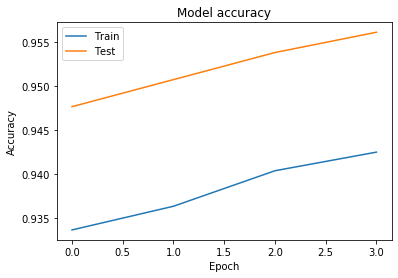

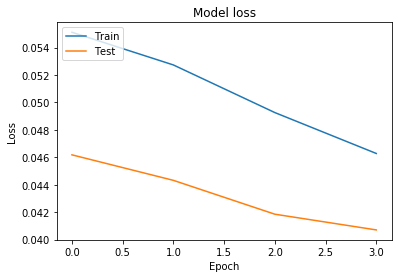

In [11]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Let's have a closer look at the results.

Typically, you would expect the training accuracy to be better than the testing accuracy (and lower loss on the training data) as the model has been exposed to the training data but not the testing data. In some unusual cases, the opposite might be true. This is usually an indication of a model or dataset that is too small or biased in one way or another, resulting in a skewed result.

You would also expect accuracies to improve and loss to decrease the more you train the network (allowing for random fluctuations in between). Accuracy would plateau once you reach the learning capacity of the network, and might even decrease when you start overfitting the network to the training set. This overfitting can be observed when the model's performance improves on the training set but begins to deteriorate on the test set.

### Tuning the dials ###
Let us try to explore changes in the network's behaviour and results by tweaking a few dials. Remember that if you want to train a network from scratch (discarding what it has learned in the previous training), you would need to recompile the model. Otherwise it would continue training from where it left off.

1.   Add more dense layers to the network. Mix up the number of neurons in each layer. Re-train and evaluate the network. Does this affect performance or training duration? Why?

2.   Try changing the number of epochs and batch size. Again, how does this affect training performance and duration?

3.   You may change the initial learning rate of the model by replacing optimizer='adam' in your model compilation with a more fleshed out equivalent: 

           optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001) 

Retrain your model. How is training different this time? Try using various learning rates in combination with varying epochs and observe their impact. What conclusions can you draw?

4.   Finally, let's explore the effects of changing the dataset itself. One simple experiment you could do would be to reduce the number of input variables used to train the model. For example: 

           input_data_train = input_data_train[:,:5] 

results in only the first 5 input variables being used. Remember to do the same for all portions of your data and then re-train your model. How is your model affected? What happens when you include or exclude more data?







## Extending to multiple classes
Logistic regression can be generalised to multiple classes. Multi-class logistic regression is often referred to as [_softmax regression_](https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html) and rather than outputting the probability of belonging to a single class, it outputs probabilities of belonging to arbitrarily many classes under the constraint that the sum over all classes equals 1. This is achieved using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function):

$$\sigma(t)_k = \frac{e^{t_k}}{\sum_{i=1}^Ke^{t_i}}$$

Here, $k$ is the class in question, $K$ is the total number of classes, and $t$ defined as in the case of standard logistic regression but now includes parameters for each output class.

In this exercise, we will convert our model from above to use softmax regression to classify wine into one of two classes (class 0: white, class 1: red).

### Reloading the dataset ###
The code block below is the same as in the previous exercise and allows you to reload your data in case you made any changes to it.

In [15]:
input_data_train, label_data_train, input_data_test, label_data_test = load_wine_data(test_frac=0.2)
print("Train data (input):", input_data_train)
print("Train data (label):", label_data_train)

print("Train data shape (input):", input_data_train.shape)
print("Train data shape (label):", label_data_train.shape)
print("Test data shape (input):", input_data_test.shape)
print("Test data shape (label):", label_data_test.shape)


Train data (input): [[15.    0.21  0.44 ...  3.07  0.84  9.2 ]
 [ 5.9   0.17  0.29 ...  3.41  0.33 13.7 ]
 [ 8.2   0.4   0.44 ...  3.53  0.61 10.5 ]
 ...
 [ 6.6   0.36  0.28 ...  3.19  0.27 12.8 ]
 [ 7.9   0.57  0.31 ...  3.29  0.69  9.5 ]
 [ 7.4   0.47  0.46 ...  3.32  0.63 10.5 ]]
Train data (label): [[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
Train data shape (input): (5198, 11)
Train data shape (label): (5198, 1)
Test data shape (input): (1299, 11)
Test data shape (label): (1299, 1)


### Converting the model for classification ###
While our data stays the same, our task has changed from regression on a single dependent variable (numerical output between 0 and 1) to 2-class classification (2 numerical outputs each representing the probability of belonging to each of the 2 classes). We therefore need to modify our model to handle this new classification task.

The code below is a copy of the same minimal model from the previous section.
Your task is to identify and implement changes to this model to allow it to perform classification across two object classes.

We will be using [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as our loss function instead of mean-squared-error. [This video (10:40)](https://www.youtube.com/watch?v=ErfnhcEV1O8) provides a good introduction to cross entropy if you are interested in the origins of the math. 

In [16]:
# Identify changes you would need to make to the basic model below to allow it to perform classification across 2 classes.
classification_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(5, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Using SparseCategoricalCrossentropy as our loss function instead of mean-squared-error
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

classification_model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

### Re-training the model and visualising results ### 
Proceed to train and test your model. Attempt to achieve or outperform the best level of performance you had in your model in the previous section.

In [17]:
print('Training the model with train data')
training_history = classification_model.fit(input_data_train, label_data_train, epochs=10, batch_size=10, validation_data=(input_data_test, label_data_test))

print('Evaluating the model with test data')
classification_model.evaluate(input_data_test, label_data_test)

Training the model with train data
Train on 5198 samples, validate on 1299 samples
Epoch 1/10
  10/5198 [..............................] - ETA: 1:59

InvalidArgumentError:  Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 1 0 0 1 1 1 1 1 1
	 [[node loss/output_1_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_distributed_function_22609]

Function call stack:
distributed_function


Here is the same visualisation code from above for your convenience.

In [22]:
4.5/np.sqrt(5)

2.0124611797498106

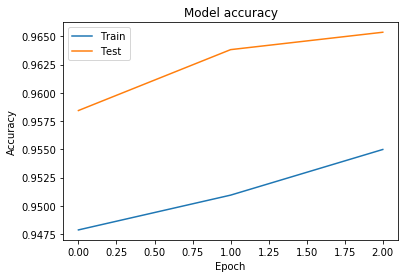

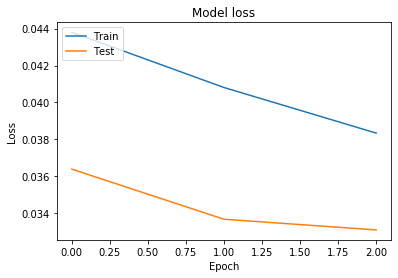

In [18]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Exploring further ###


1.   We have so far only used the "accuracy" metric to judge the performance of our model. This may or may not be the most suitable metric to use depending on the application. Here are some [metrics](https://keras.io/metrics/) that Keras supports. Try adding some of them to your model and see what works for you. 

2.   The measurements of accuracy you get from the above metrics would vary as each metric has its own method of computation. Try determining your own rules for measuring accuracy in your model and then implementing your own python script to calculate model performance. You may infer data points through your model simply by using: 

         predictions = model(input).numpy()

The function returns a numpy array of the model's predictions which you can then compare with the corresponding labels to determine the error/accuracy.

3.   Try creating your own wine samples by making up artificial data points. Introduce some extremities in your data. Pass these through your network. How does your network react to fake and possibly outlier data? Does this pose a threat to model reliability and accuracy? How would you overcome this issue? Try implementing a solution.


 


This is the end of the exercise. Thanks for participating!

We hope you are now confident to take your first steps into the world of Deep Learning and Neural Networks.